<a href="https://colab.research.google.com/github/JakobWyatt/autonomous-wheelchair-thesis/blob/main/colab/Machine_Perception_CNN_Crash_Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks - Crash Course
The objective of today's practical is to get some familiarity with Convolutional Neural Networks (CNNs). We won't go into the details of implementing these things from scratch, rather we will cover how to take a "pretrained" network and apply it to new problem. 99% of the time, this is a very effective way of utilising CNNs to solve real problems.

## Image Classification on Oxford Pets
The first task we're going to look at is an image classification problem where you must identify the species of cat or dog.

This practical is heavily based on the course  [Practical Deep Learning for Coders](https://course.fast.ai/). As such we will utilise their fastai library, which is built on top of PyTorch. So the first thing to do is install the library, then import it. Fastai also provides easy access to some popular datasets, so we'll use that to download and extract it the Oxford Pets dataset, which we're going to use as an example.

### Important Setup
Training CNNs requires a lot of computing power. They are typically trained on GPUs or specialised ASICs. If you wish to run this and get results before you graduate you'll need an NVIDIA GPU (it is technically possible to use an AMD card, but it is poorly supported). 

You can access up to 12 hours of free GPU compute from [Google Colaboratory](https://colab.research.google.com). This is the recommended setup for running this practical. Make sure you go to **Runtime -> Change Runtime Type** and enable the GPU or you're going to be waiting weeks for these things to run.



In [ ]:
# Installing the base library we need
!pip install --upgrade fastai

     |████████████████████████████████| 194kB 2.0MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
# Import required libraries, and set the random seed to improve repeatability

%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *

set_seed(42)

In [ ]:
# Download the data and set the file paths

path = untar_data(URLs.PETS)
Path.BASE_PATH = path
path_anno = path/'annotations'
path_img = path/'images'
path_img.ls()

(#7393) [Path('images/shiba_inu_124.jpg'),Path('images/Bengal_57.jpg'),Path('images/german_shorthaired_187.jpg'),Path('images/english_setter_197.jpg'),Path('images/Maine_Coon_126.jpg'),Path('images/american_pit_bull_terrier_146.jpg'),Path('images/miniature_pinscher_188.jpg'),Path('images/Bombay_132.jpg'),Path('images/Abyssinian_44.jpg'),Path('images/leonberger_71.jpg')...]

### Creating Dataloaders
Now that we have our data, we need to load it. This dataset is on the smaller side, but still way too big to put into memory. Instead we need to construct some dataloaders to read the images, label them, and perform any other data preparation we need for the model.

As we can see from the `ls()` function, each image is named in the format "\<Class>_\<num>.jpg", so we can parse this with a regular expression. To create a batch, we also need to make sure each item is the same size, so lets resize everything to 224x224 (this is a standard input size for most image classification models).

The model we'll be using is "pretrained" (i.e. it has been trained on a different dataset first). When trained the images are normalised by the mean and standard deviations of the dataset. To avoid any issues, we should normalise our images by the same values, so we'll do that to every batch.

In [ ]:
fnames = get_image_files(path_img)  # This finds all the image files in the path
dls = ImageDataLoaders.from_name_re( # and this constructs the dataloaders
    path, 
    fnames, 
    pat=r'(.+)_\d+.jpg$', 
    item_tfms=Resize(224), 
    bs=64,
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

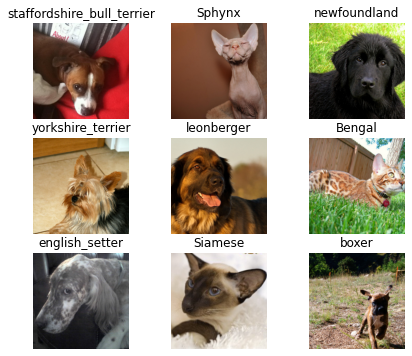

In [ ]:
dls.show_batch(max_n=9, figsize=(7,6))

### Creating a model

Now we need to create our model. fastai provides a convenience function `cnn_learner` to do this, you just pass in your data, a model constructor function, and any metrics you want.

We're going to use AlexNet as our model, this model won the ImageNet challenge in 2012 and is largely credited with the deep learning boom in computer vision.

In [ ]:
learn = cnn_learner(dls, alexnet, metrics=error_rate)  # this creates our custom Alexnet-based model

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


### Training
Now it's as simple as telling the model to fit the data, and measuring the performance. We'll run 4 epochs (4 iterations through the dataset) and save the result when we're done.

In [ ]:
learn.fit_one_cycle(4)  # Our training loop, all in one line
learn.save('stage-1')  # Save our model so we can restore it

epoch,train_loss,valid_loss,error_rate,time
0,3.200713,1.193365,0.365359,00:48
1,1.656043,0.775951,0.236806,00:46
2,1.165433,0.697344,0.209066,00:45
3,0.981288,0.687884,0.208390,00:45


Path('models/stage-1.pth')

### Evaluating our model
Okay, so clearly we've learned something, but we're not doing great. Lets have a look at our results and get a feel for the failures

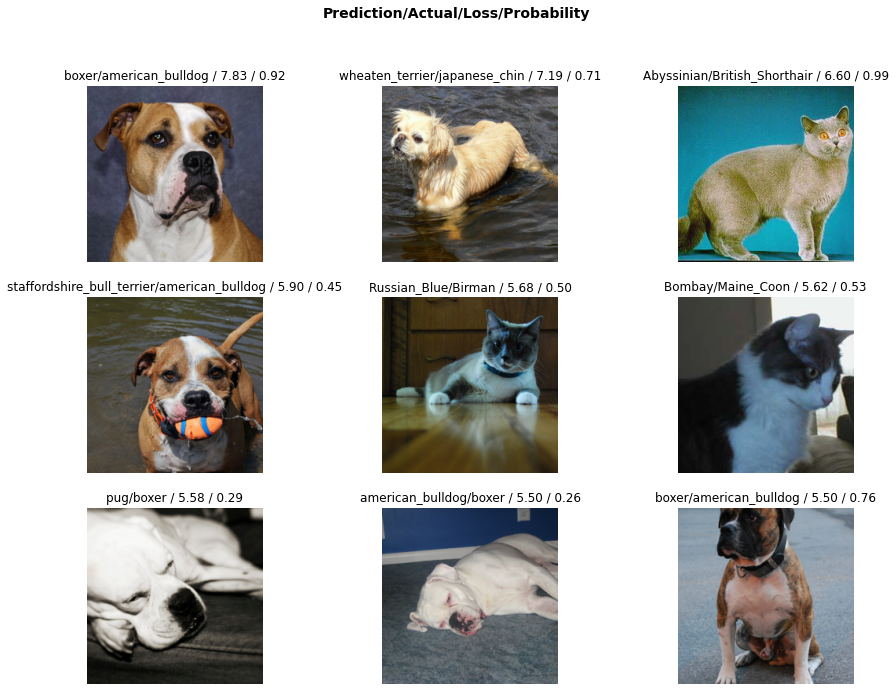

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

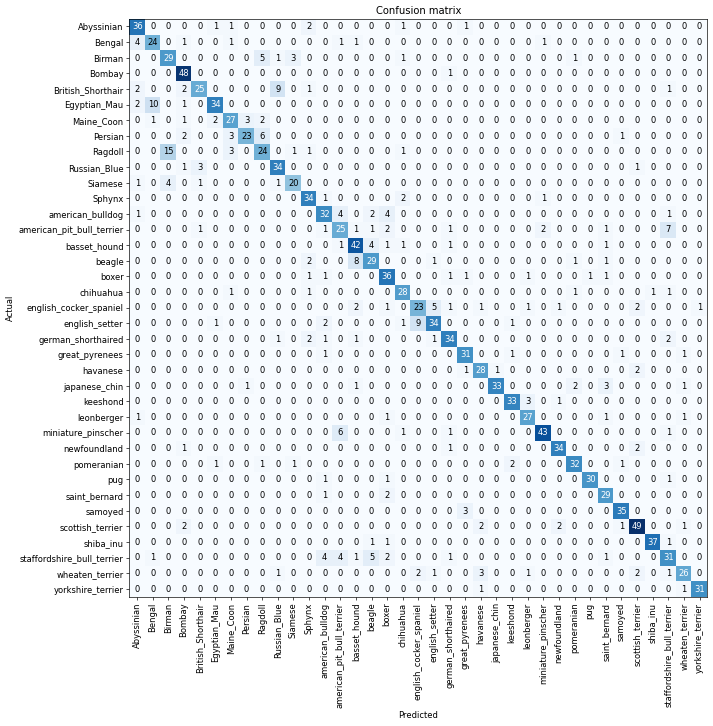

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 15),
 ('Egyptian_Mau', 'Bengal', 10),
 ('British_Shorthair', 'Russian_Blue', 9),
 ('english_setter', 'english_cocker_spaniel', 9),
 ('beagle', 'basset_hound', 8),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Persian', 'Ragdoll', 6),
 ('miniature_pinscher', 'american_pit_bull_terrier', 6),
 ('Birman', 'Ragdoll', 5),
 ('english_cocker_spaniel', 'english_setter', 5),
 ('staffordshire_bull_terrier', 'beagle', 5),
 ('Bengal', 'Abyssinian', 4),
 ('Siamese', 'Birman', 4),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('american_bulldog', 'boxer', 4),
 ('basset_hound', 'beagle', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Birman', 'Siamese', 3),
 ('Maine_Coon', 'Persian', 3),
 ('Persian', 'Maine_Coon', 3),
 ('Ragdoll', 'Maine_Coon', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('japanese_chin', 'saint_bernard', 3),
 ('keeshond', 'leonberger', 3),
 ('sam

Looking at these results we just seem to be generally doing poorly. There are a few different ways to combat this: more robust augmentation, and/or bigger models. Lets try adding some augmentation and running again. We'll need to recreate our model so we can start clean. fastai provides easy access to some common options via `aug_transforms`

In [ ]:
dls = ImageDataLoaders.from_name_re(
    path, 
    fnames, 
    pat=r'(.+)_\d+.jpg$', 
    item_tfms=Resize(460), # resize each image to be 460x460
    bs=64,
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]  # Randomly crop and resize to get a 224x224 region for each image, and normalize the RGB channels
)
learn = cnn_learner(dls, alexnet, metrics=error_rate)
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,3.306608,1.255633,0.365359,01:04
1,1.709063,0.807102,0.239513,01:04
2,1.234833,0.713041,0.209066,01:04
3,1.085038,0.703722,0.211096,01:02


Path('models/stage-1.pth')

Okay, that really isn't much better. I guess AlexNet must just be a little too simple for our task here. Lets try a bigger model too, see if that gets us better performance. ResNet34 is a newer, deeper model that can learn more informative features so lets see how that goes.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)  #use a resnet34 instead of alexnet
learn.fit_one_cycle(4)
learn.save('stage-1')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.945801,0.334881,0.109608,01:04
1,0.704106,0.258295,0.085927,01:03
2,0.437881,0.225101,0.071042,01:04
3,0.342228,0.218010,0.070365,01:05


Path('models/stage-1.pth')

That's better! There's a bit of an art to getting this right, so you need to play around with different models, augmentation, and other settings (called "hyperparameters")

### Fine-tuning

But can we do better? Well so far we've actually only been training the last layer of the network, the earlier stages have been kept fixed to avoid overfitting. Lets try unfreezing the rest of the network and training the whole thing

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.356408,0.609617,0.186739,01:08


Uh oh, that didn't work at all. The most likely reason here is that we're updating our weights too much, which has caused us to diverge. We can reload our previous weights, and then use `lr_find()` to get an idea of some learning rates that might be more suitable.

SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=1.0964781722577754e-06)

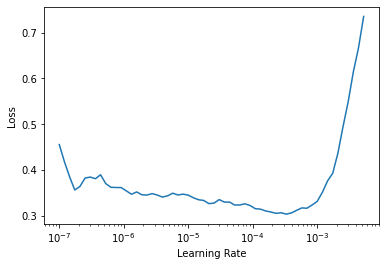

In [ ]:
learn.load('stage-1')
learn.lr_find()

This graph is a loss graph, so good settings are going to lie around the range where there's a downward slope. Rather than setting the whole network to one rate, we're actually going to take a range from the start of the slope to the base of it. This sets the earlier layers to a much slower update rate than the later layers, which usually yields good performance.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.298456,0.206370,0.064953,01:08
1,0.289409,0.203021,0.064276,01:08


Spend some time trying out the different options you have available to you and see how well you can classify this dataset. Check out the docs for [`aug_transforms`](https://dev.fast.ai/vision.augment#aug_transforms) to see what augmentation you can do, and [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) to see what model structures are available.

In [ ]:
## Your code goes here

## Image Segmentation on CamVid

Lets try another, more difficult problem. Image Segmentation on CamVid.

Image Segmentation attempts to label every pixel in the image, rather than just the image overall. CamVid is an autonomous driving dataset, so you're attempting to determine what is road, footpath, building, traffic lights, and so on. Obviously this is a pretty important problem for building autonomous vehicles.

## Setup
First we go through all the same data prep as before. This time our labels are also images (since we're labelling every pixel the easiest representation is an image where 0 is background, and 1..N are the classes).

In [ ]:
# Get all the data for this new dataset
path = untar_data(URLs.CAMVID)
path_lbl = path/'labels'
path_img = path/'images'
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

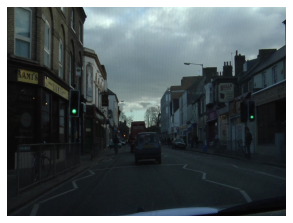

In [ ]:
img_f = fnames[0]
img = PILImage.create(img_f)
img.show(figsize=(5,5))

Here we're going to need a way to map from the image to it's corresponding label image so we'll make a quick lambda for that

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

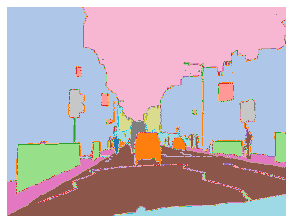

In [ ]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes  # These are the labels in the images

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

CamVid has a fixed validation set, so we should grab that and use it to split our dataset. This time we're going to use the `DataBlock` API from fastai to build our dataset, as it provides more flexibility in our data structure

In [ ]:
# This splits our training data from our validation data
def FileSplitter(fname):
  with open(fname, 'r') as f:
    valid = f.read().split('\n')
  #valid = Path(fname).read().split('\n')
  def _func(x): return x.name in valid
  def _inner(o, **kwargs): return FuncSplitter(_func)(o)
  return _inner

In [ ]:
camvid = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    splitter=FileSplitter(path/'valid.txt'),
    get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=[*aug_transforms(size=(380,480)), Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = camvid.dataloaders(path/'images', bs=8, path=path)

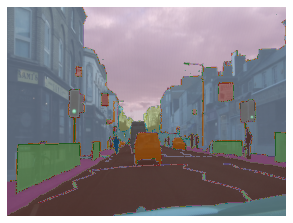

In [ ]:
show_at(dls.train_ds, 0)

###  Model
Now we can't just use the exact same model structure as before, since that only outputs one value. But the nice thing about CNNs is that most architectures are built to be adaptable. In this case we're going to create what's called a UNet, using ResNet34 as a base. UNets were originally designed for medical image segmentation, but they work well for most segmentation tasks.

We also need to make a custom accuracy metric to measure this right, since error rate doesn't quite work

In [ ]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [ ]:
metrics = acc_camvid
dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=metrics)

### Training

Now we have a model, lets find a learning rate and train. We're going to add in another couple of options this time: Setting `pct_start` to 0.9 keeps the learning rate higher for longer, and `wd` controls "weight decay" also known as L2 regularisation.

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.00015848931798245758)

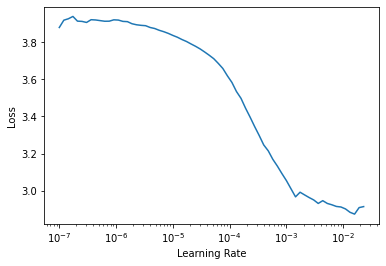

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, slice(3e-3), pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.248040,0.801840,0.793087,00:56
1,0.848252,0.599888,0.835156,00:53
2,0.720466,0.599767,0.844943,00:53
3,0.623596,0.582908,0.858510,00:53
4,0.625291,0.511826,0.853779,00:53
5,0.642951,0.813347,0.776309,00:53
6,0.584915,0.428940,0.891318,00:53
7,0.580179,0.430080,0.873413,00:53
8,0.519732,0.424891,0.880999,00:53
9,0.457280,0.357506,0.889431,00:53


In [ ]:
learn.save('stage-1')
learn.load('stage-1')

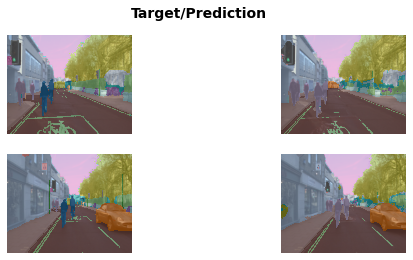

In [ ]:
learn.show_results(max_n=4, figsize=(9,4))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(12, slice(3e-3/400, 3e-3/4), pct_start=0.8, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.388367,0.332268,0.897747,00:55
1,0.375200,0.327799,0.899018,00:55
2,0.369842,0.318507,0.901646,00:55
3,0.359449,0.294537,0.918649,00:55
4,0.348357,0.305971,0.910215,00:55
5,0.339011,0.303069,0.913882,00:55
6,0.333673,0.290789,0.918004,00:55
7,0.319150,0.302218,0.912127,00:55
8,0.308357,0.291198,0.914140,00:55
9,0.301136,0.290955,0.917879,00:55


Again play around here with the options you have and try to get better results. You can make the images bigger, use bigger models, more/different augmentation, etc.